
# ribo-gcamp

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pickle
import pandas as pd
from scipy.signal import detrend #for bleach correction
from scipy import optimize
from scipy.spatial import distance



## load traces

In [7]:
with open('data/traces.pkl', 'rb') as f:
    data = pickle.load(f)  
print('there are ' + str(len(data))+' traces')
f.close()

there are 105 traces


## define function to find rise transients, using peakfinding method

In [8]:
from peakfind import peakfind

def risetimes(timeseries, sm=20, thresh=5):
 
    #3-value box filter
    xs=timeseries
    # find peaks
    peaks, _ = peakfind(xs,thresh=thresh,relthreshflag=True)
    rise_start_frames=np.zeros(len(peaks))
    numframes=np.zeros(len(peaks))
    
    # derivative of smoothed timeseries
    xd=np.diff(timeseries.rolling(sm).mean())
    
    # count backwards from peaks
    for p in range(len(peaks)):
        j=peaks[p]-1
        num=0
        while np.nan_to_num(xd[j]) > 0 and j > 0:
            num=num+1
            j=j-1
        numframes[p]=num
    
    rise_end_frames = peaks
    rise_start_frames = np.subtract(peaks,numframes)
    rise_start_frames = rise_start_frames.astype(int)  #hack
    return rise_start_frames, rise_end_frames

## measure all rise transients

In [9]:
threshold=.4
smoothing=40
for d in data:
    data[d]['rise_start_frames'],data[d]['rise_end_frames'] = risetimes(data[d]['dFF'],thresh=threshold,sm=smoothing)
    data[d]['risetimes']=np.zeros(len(data[d]['rise_start_frames']))
    for t in range(len(data[d]['rise_start_frames'])):
        data[d]['risetimes'][t]=data[d]['time_sec'][data[d]['rise_end_frames'][t]] - data[d]['time_sec'][data[d]['rise_start_frames'][t]]
        
        

## save to .pkl

In [13]:
# write python dict to a file
output = open('data/traces.pkl', 'wb')
pickle.dump(data, output)
output.close()

## plot traces with detected transients overlaid

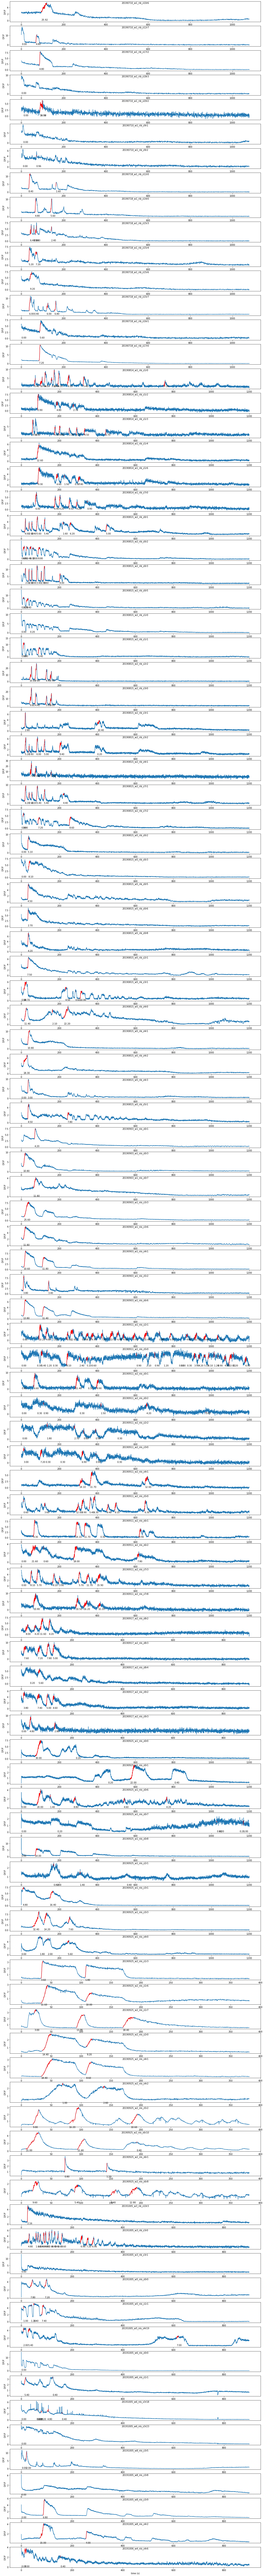

In [8]:
num_traces=len(data)
figsize = (20, 2*num_traces)
fig = plt.figure(figsize=figsize)
for d,t in zip(data,range(num_traces)):
    ax = plt.subplot(num_traces,1,t+1)
    ax.plot(data[d]['time_sec'],data[d]['dFF'])
    for r in range(len(data[d]['risetimes'])):
        r1=data[d]['rise_start_frames'][r]
        r2=data[d]['rise_end_frames'][r]
        ax.plot(data[d]['time_sec'][r1:r2],data[d]['dFF'][r1:r2],'r')
        ax.text(data[d]['time_sec'][r1],0,"{:.2f}".format(data[d]['risetimes'][r]))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('DF/F')
    ax.text(.5,.9,d,
    horizontalalignment='center',
    fontsize=10,
    transform=ax.transAxes)

fig.savefig("traces_with_risetimes-sm"+ str(smoothing)+ "-tr"+ str(threshold) +".pdf", bbox_inches='tight')

## histograms of risetimes, throwing out spurious fast events

In [11]:
rib_risetimes=[]
nls_risetimes=[]

min_thresh=1.5

for d in data:
    if data[d]['GCaMPtype']=='rib':
        rib_risetimes.extend(list(filter(lambda x: (x > min_thresh),list(data[d]['risetimes']))))
    else:
        nls_risetimes.extend(list(filter(lambda x: (x > min_thresh),list(data[d]['risetimes']))))

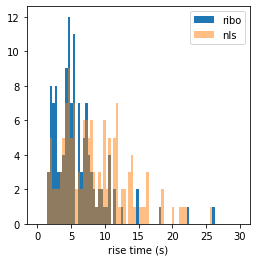

In [12]:
figsize = (4, 4)
fig = plt.figure(figsize=figsize)

_, bins, _ = plt.hist(rib_risetimes,range=[0, 30],bins=80,label='ribo')
_ = plt.hist(nls_risetimes,range=[0, 30],bins=bins,label='nls',alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel("rise time (s)")
plt.show()
fig.savefig('histogram_all_ribo_vs_nls' + str(smoothing)+ "-tr"+ str(threshold) + '.pdf', bbox_inches='tight')

# Modeling the temporal transformation between ribo and nls

## create synthetic ribo-gcamp ramp trace generator

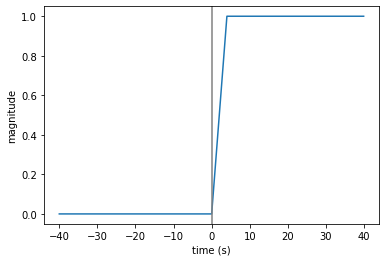

In [98]:
time_vec=np.arange(-40,40,0.1)

def gen_ribo_trace(rise_time,in_time_vec):
    out_vec=np.zeros(len(time_vec))
    for i in range(len(time_vec)):
        if in_time_vec[i]>0:
            if in_time_vec[i]<rise_time:
                out_vec[i]=in_time_vec[i]/rise_time
            else:
                out_vec[i]=1.0
                                   
    return out_vec 

fig, ax = plt.subplots()
plt.plot(time_vec,gen_ribo_trace(4.0,time_vec))
plt.xlabel("time (s)")
plt.ylabel("magnitude")
ax.axvline(x=0, color='gray')
plt.show()

## create first-order impulse response function


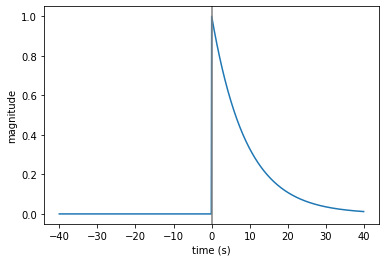

In [99]:
def gen_irf(tau,in_time_vec):
    out_vec=np.zeros(len(in_time_vec))
    for i in range(len(in_time_vec)):
        if in_time_vec[i]>0:
                out_vec[i]=np.exp(-in_time_vec[i]/tau)
    return out_vec

time_vec=np.arange(-40,40,0.1)
fig, ax = plt.subplots()
plt.plot(time_vec,gen_irf(9.0,time_vec))
plt.xlabel("time (s)")
plt.ylabel("magnitude")
ax.axvline(x=0, color='gray')
plt.show()

## create nls trace generator as convolution of ribo-gcamp traces and irf

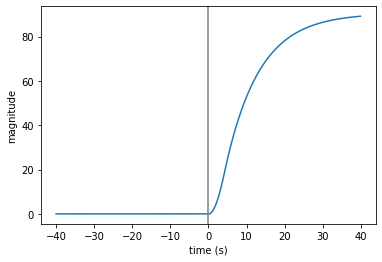

In [100]:
def gen_nls_trace(rise_time,tau,in_time_vec):   
    convolved_vec=np.convolve(gen_ribo_trace(rise_time,in_time_vec),gen_irf(tau,in_time_vec),mode='same') 
    out_vec=convolved_vec
    return out_vec


fig, ax = plt.subplots()
plt.plot(time_vec,gen_nls_trace(4.0,9.0,time_vec))
plt.xlabel("time (s)")
plt.ylabel("magnitude")
ax.axvline(x=0, color='gray')
plt.show()

## measure rise time of trace

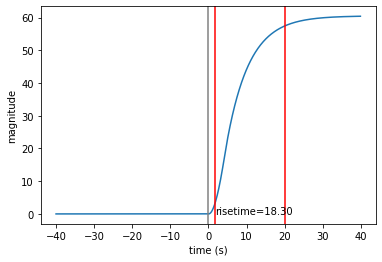

In [101]:
def measure_rise_time(trace,in_time_vec,threshold_low=0.05,threshold_high=0.95):
    
    # find start time
    start_time=in_time_vec[np.argmax(trace > (max(trace)-min(trace))*threshold_low+min(trace))]
    
    # find end time
    end_time=in_time_vec[np.argmax(trace > (max(trace)-min(trace))*threshold_high+min(trace))]

    rise_time = end_time - start_time
    return rise_time, start_time, end_time
 
    
test_trace=gen_nls_trace(4.0,6.0,time_vec)       
test_rise_time, test_start_time, test_end_time = measure_rise_time(test_trace,time_vec)
    
fig, ax = plt.subplots()
plt.plot(time_vec,gen_nls_trace(4.0,6.0,time_vec))
plt.text(test_start_time, 0, 'risetime={:.2f}'.format(test_rise_time))
plt.xlabel("time (s)")
plt.ylabel("magnitude")
ax.axvline(x=0, color='gray')
ax.axvline(x=test_start_time, color='red')
ax.axvline(x=test_end_time, color='red')
plt.show()

## transform ribo-gcamp rise times into nls-gcamp rise times given an i.r.f. tau

In [364]:
def transform_rise_times(ribo_vec,tau):
    
    this_time_vec=np.arange(-40,40,0.1)
    nls_vec=[]
    
    for time in ribo_vec:
        rt, _, _ = measure_rise_time(gen_nls_trace(time,tau,this_time_vec),this_time_vec,
                                     threshold_low=0.05,threshold_high=0.99)
        nls_vec = np.append(nls_vec,rt)
    
    return nls_vec


## create synthetic test data

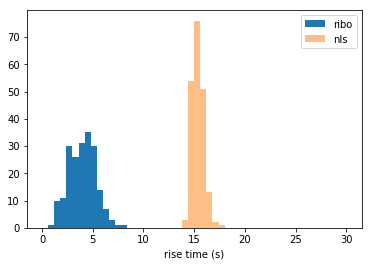

In [369]:
test_ribo=abs((np.random.randn(200)*1.3)+4)

test_nls=transform_rise_times(test_ribo,tau=3.1)

_, bins, _ = plt.hist(test_ribo,range=[0, 30],bins=50,label='ribo')
_ = plt.hist(test_nls,range=[0, 30],bins=bins,label='nls',alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel("rise time (s)")
plt.show()

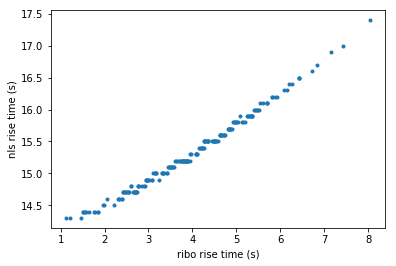

In [370]:
plt.plot(test_ribo,test_nls,'.')
plt.xlabel("ribo rise time (s)")
plt.ylabel("nls rise time (s)")
plt.show()

## define histogram-comparison error function

In [367]:
def error_func(tau,vec1,vec2,num_bins=30,range=[0, 20]):
    
    # make hist
    hist_exper=np.histogram(vec2,bins=num_bins,range=range)
    
    # transform rise_times
    vec2_model = transform_rise_times(vec1,tau)
    hist_model=np.histogram(vec2_model,bins=num_bins,range=range)
    
    # compare hists
    err=distance.euclidean(hist_exper[0],hist_model[0])
    return err 

## find tau that best explains data

In [371]:
res=optimize.minimize(error_func,2.5,args=(test_ribo, test_nls),method='nelder-mead',options={'disp': True})
res.x[0]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 34


3.099609375

## plot tau error landscape

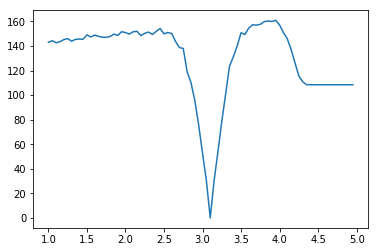

In [368]:
my_tau_vec = np.arange(1,5,0.05)
my_error_vec = []
for my_tau in my_tau_vec:
    my_error_vec=np.append(my_error_vec,error_func(my_tau,test_ribo,test_nls))
    
plt.plot(my_tau_vec,my_error_vec)    
plt.show()

# Now run this model on experimental data- comparing ribo and nls aggregate data

## create time series excerpts of ribo rise transients

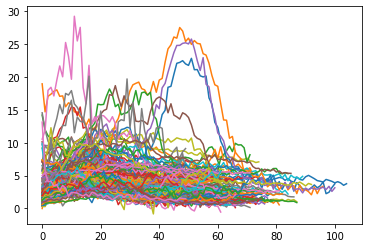

In [189]:
rib_excerpts_dFF=[] 
rib_excerpts_time_sec=[]
for d in data:
    if data[d]['GCaMPtype']=='rib':
        for r in range(len(data[d]['rise_start_frames'])):
            rib_excerpts_dFF.append(data[d]['dFF'][data[d]['rise_start_frames'][r]:(50+data[d]['rise_end_frames'][r])])
            rib_excerpts_time_sec.append(data[d]['time_sec'][data[d]['rise_start_frames'][r]:(50+data[d]['rise_end_frames'][r])])

for x in rib_excerpts_dFF:
    plt.plot(x.values)
    

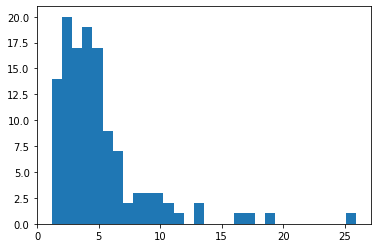

In [190]:
risetimes_rib=[]
for r,t in zip(rib_excerpts_dFF,rib_excerpts_time_sec):
    if not r.empty:
        rt,_,_ = measure_rise_time(r.values,t.values,threshold_low=0.05,threshold_high=0.95)
        risetimes_rib.append(rt)
risetimes_rib=list(filter(lambda x: (x > min_thresh),risetimes_rib))
plt.hist(risetimes_rib,bins=30)
plt.show()

## function to convolve 1st order filter

In [191]:
def gen_irf(tau,in_time_vec):
    out_vec=np.zeros(len(in_time_vec))
    for i in range(len(in_time_vec)):
        if in_time_vec[i]>0:
                out_vec[i]=np.exp(-in_time_vec[i]/tau)
    return out_vec


def convolve_ribo_trace(ribo_trace,tau,in_time_vec):   
    convolved_vec=np.convolve(ribo_trace,gen_irf(tau,in_time_vec),mode='same') 
    return convolved_vec

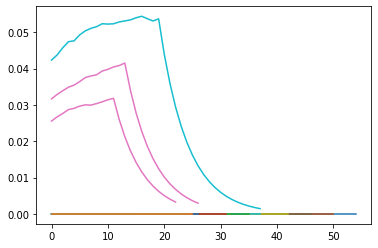

In [158]:
tau=1
for r,t in zip(rib_excerpts_dFF,rib_excerpts_time_sec):
    if not r.empty:
        plt.plot(convolve_ribo_trace(r.values,tau,t.values))

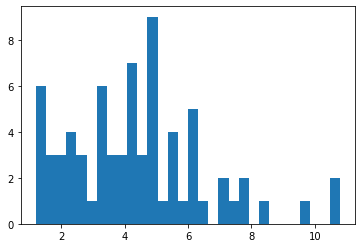

In [199]:
def make_nls_traces(tau=10):
    risetimes_sim=[]
    for r,t in zip(rib_excerpts_dFF,rib_excerpts_time_sec):
        if not r.empty:
            nls_sim_trace=convolve_ribo_trace(r.values,tau,t.values)
            rt,_,_ = measure_rise_time(nls_sim_trace,t.values,threshold_low=0.05,threshold_high=0.95)
            risetimes_sim.append(rt)
        risetimes_sim=list(filter(lambda x: (x > min_thresh),risetimes_sim))     
    return risetimes_sim  


plt.hist(make_nls_traces(7),bins=30)
plt.show()

## create time series excerpts of nls rise transients

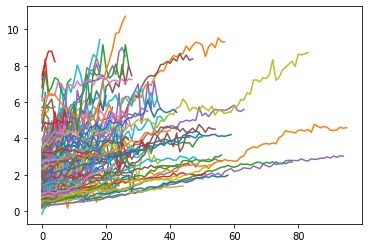

In [69]:
nls_excerpts_dFF=[] 
nls_excerpts_time_sec=[]
for d in data:
    if data[d]['GCaMPtype']=='nls':
        for r in range(len(data[d]['rise_start_frames'])):
            nls_excerpts_dFF.append(data[d]['dFF'][data[d]['rise_start_frames'][r]:data[d]['rise_end_frames'][r]])
            nls_excerpts_time_sec.append(data[d]['time_sec'][data[d]['rise_start_frames'][r]:data[d]['rise_end_frames'][r]])

for x in nls_excerpts_dFF:
    plt.plot(x.values)

<function matplotlib.pyplot.show(*args, **kw)>

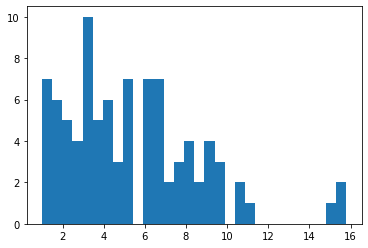

In [139]:
risetimes_nls_actual=[]

for r,t in zip(nls_excerpts_dFF,nls_excerpts_time_sec):
    if not r.empty:
        rt,_,_ = measure_rise_time(r.values,t.values,threshold_low=0.05,threshold_high=0.95)
        risetimes_nls_actual.append(rt)

risetimes_nls_actual=list(filter(lambda x: (x > min_thresh),risetimes_nls_actual))   
plt.hist(risetimes_nls_actual,bins=30)
plt.show        

In [169]:
def hist_error_func(tau):

    num_bins=30
    range=[0, 10]
    
    # make hists
    hist_exper=np.histogram(make_nls_traces(tau),bins=num_bins,range=range)
    hist_model=np.histogram(risetimes_nls_actual,bins=num_bins,range=range)
    
    # compare hists
    err=distance.euclidean(hist_exper[0],hist_model[0])
    return err 

In [185]:
res=optimize.minimize(hist_error_func,3,method='nelder-mead',options={'disp': True})
res.x[0]

Optimization terminated successfully.
         Current function value: 24.637370
         Iterations: 15
         Function evaluations: 38


3.5062500000000014

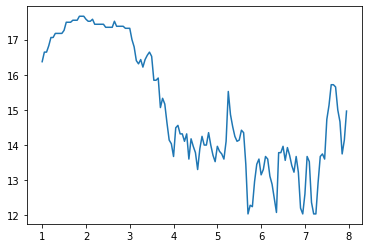

In [200]:
my_tau_vec = np.arange(1,8,0.05)
my_error_vec = []
for my_tau in my_tau_vec:
    my_error_vec=np.append(my_error_vec,hist_error_func(my_tau))
    
plt.plot(my_tau_vec,my_error_vec)    
plt.show()

In [ ]:
res=optimize.minimize(error_func,2.5,args=(test_ribo, test_nls),method='nelder-mead',options={'disp': True})
res.x[0]